In [1]:
import networkx as nx
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

In [3]:
def gerar_ciclos_impares(n_exemplos, min_n=3, max_n=15):
    vistos = set()
    contador_por_tamanho = defaultdict(int)

    grafos = []
    for _ in range(n_exemplos):
        n = random.choice([i for i in range(min_n, max_n + 1) if i % 2 == 1])
        G = nx.cycle_graph(n)
        grafos.append(G)
        contador_por_tamanho[n] += 1

    print(f"Total de grafos gerados: {len(grafos)}")
    print(f"Total de grafos únicos: {len(vistos)}")
    print("Distribuição por número de nós (apenas ímpares):")
    for n in sorted(contador_por_tamanho):
        print(f"  - {n} nós: {contador_por_tamanho[n]} grafos")

    return grafos

In [4]:
f_grafos = gerar_ciclos_impares(10000, 10, 20)

Total de grafos gerados: 10000
Total de grafos únicos: 0
Distribuição por número de nós (apenas ímpares):
  - 11 nós: 2099 grafos
  - 13 nós: 2028 grafos
  - 15 nós: 1945 grafos
  - 17 nós: 2015 grafos
  - 19 nós: 1913 grafos


In [4]:
# def contar_3paths_por_no(G):
#     count_3paths = {node: 0 for node in G.nodes()}
#     # Para cada aresta (u,v), buscamos caminhos de comprimento 3 que a contenham
#     for u in G.nodes():
#         for v in G.neighbors(u):
#             for w in G.neighbors(v):
#                 if w == u:
#                     continue
#                 for x in G.neighbors(w):
#                     if x in {u,v,w}:
#                         continue
#                     # Temos um caminho u-v-w-x (4 nós diferentes, 3 arestas)
#                     # Incrementa contagem para cada nó do caminho
#                     for node in [u, v, w, x]:
#                         count_3paths[node] += 1
#     # Cada caminho é contado múltiplas vezes (4 vezes, uma para cada nó)
#     for node in count_3paths:
#         count_3paths[node] //= 4
#     return count_3paths

# def adicionar_features_completas(lista_grafos):
#     for G in lista_grafos:
#         eigen_centrality = nx.eigenvector_centrality(G)
#         degrees = dict(G.degree())
#         media_graus = np.mean(list(degrees.values()))
#         count_3paths = contar_3paths_por_no(G)
        
#         for node in G.nodes():
#             G.nodes[node]['eigenvector_centrality'] = eigen_centrality[node]
#             G.nodes[node]['degree'] = degrees[node]
#             G.nodes[node]['mean_degree'] = media_graus
#             G.nodes[node]['3paths'] = count_3paths[node]

#             # Criação do vetor de features
#             feature_vec = np.array([
#                 eigen_centrality[node],
#                 degrees[node],
#                 media_graus,
#                 count_3paths[node]
#             ], dtype=float)

#             G.nodes[node]['feature'] = feature_vec
#     return lista_grafos


In [5]:
#f_grafos = adicionar_features_completas(grafos)

In [6]:
# grafo_5_nos = None
# for G in f_grafos:
#     if G.number_of_nodes() == 5:
#         grafo_5_nos = G
#         break

# if grafo_5_nos is not None:
#     print("Atributos dos nós do grafo com 5 nós:")
#     for node, attrs in grafo_5_nos.nodes(data=True):
#         print(f"Nó {node}: {attrs}")
# else:
#     print("Não foi encontrado grafo com 5 nós na lista.")

In [5]:
# --- Funções auxiliares ---

# def relu(x):
#     return np.maximum(0, x)

# def relu_deriv(x):
#     return (x > 0).astype(float)

#Usando a função ReLU com um pequeno coeficiente alpha para evitar zeros
def relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x) 

def relu_deriv(x, alpha=0.01):
    return np.where(x > 0, 1.0, alpha)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

In [6]:
# --- Inicialização ---
np.random.seed(42)
feature_dim = 1
latent_dim = 2

W_mu = np.random.randn(feature_dim, latent_dim) * 0.1
W_logvar = np.random.randn(feature_dim, latent_dim) * 0.1
W_dec1 = np.random.randn(latent_dim*2, latent_dim*2) * 0.1
b_dec1 = np.zeros(latent_dim*2)
W_dec2 = np.random.randn(latent_dim*2, 1) * 0.1
b_dec2 = np.zeros(1)

lr = 0.1
epochs = 100

In [7]:
# --- Função auxiliar ---
def preparar_matriz_adjacencia_e_features(G):
    A = nx.to_numpy_array(G, dtype=float)
    np.fill_diagonal(A, 1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(A.sum(axis=1) + 1e-10))
    A_hat = D_inv_sqrt @ A @ D_inv_sqrt
    H0 = np.ones((G.number_of_nodes(), 1))  # features constantes = 1
    return A_hat, A, H0

In [8]:
# --- Treinamento ---
for epoch in range(epochs):
    total_loss = 0
    for G in f_grafos:
        A_hat, A, H0 = preparar_matriz_adjacencia_e_features(G)
        N = A.shape[0]

        # --- Encoder ---
        M = A_hat @ H0
        mu = M @ W_mu
        logvar = M @ W_logvar
        eps = np.random.randn(*mu.shape)
        std = np.exp(0.5 * logvar)
        Z = mu + std * eps

        # --- Decoder ---
        A_pred = np.zeros_like(A)
        cache = {}
        for i, j in product(range(N), repeat=2):
            z_ij = np.concatenate([Z[i], Z[j]])
            h1 = relu(z_ij @ W_dec1 + b_dec1)
            out = sigmoid(h1 @ W_dec2 + b_dec2)
            A_pred[i, j] = out
            cache[(i, j)] = (z_ij, h1, out)

        # --- Perda ---
        bce = -np.mean(A * np.log(A_pred + 1e-10) + (1 - A) * np.log(1 - A_pred + 1e-10))
        kl = -0.5 * np.mean(1 + logvar - mu**2 - np.exp(logvar))
        loss = bce + kl
        total_loss += loss

        # --- Backprop decoder ---
        dW_dec1 = np.zeros_like(W_dec1)
        db_dec1 = np.zeros_like(b_dec1)
        dW_dec2 = np.zeros_like(W_dec2)
        db_dec2 = np.zeros_like(b_dec2)
        dZ = np.zeros_like(Z)

        for i, j in product(range(N), repeat=2):
            z_ij, h1, out = cache[(i, j)]
            dL_dout = - (A[i, j] / (out + 1e-10) - (1 - A[i, j]) / (1 - out + 1e-10)) / (N * N)
            delta2 = dL_dout * sigmoid_deriv(h1 @ W_dec2 + b_dec2)
            dW_dec2 += np.outer(h1, delta2)
            db_dec2 += delta2

            delta1 = (delta2 @ W_dec2.T) * relu_deriv(z_ij @ W_dec1 + b_dec1)
            dW_dec1 += np.outer(z_ij, delta1)
            db_dec1 += delta1

            dz_ij = delta1 @ W_dec1.T
            dZ[i] += dz_ij[:latent_dim]
            dZ[j] += dz_ij[latent_dim:]

        # --- Backprop encoder ---
        dZ_dmu = 1
        dZ_dlogvar = 0.5 * std * eps
        dL_dmu = dZ * dZ_dmu + mu / mu.size
        dL_dlogvar = dZ * dZ_dlogvar + 0.5 * (np.exp(logvar) - 1) / logvar.size
        dW_mu = (A_hat @ H0).T @ dL_dmu
        dW_logvar = (A_hat @ H0).T @ dL_dlogvar

        # --- Atualização pesos ---
        W_mu -= lr * dW_mu
        W_logvar -= lr * dW_logvar
        W_dec1 -= lr * dW_dec1
        b_dec1 -= lr * db_dec1
        W_dec2 -= lr * dW_dec2
        b_dec2 -= lr * db_dec2

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Avg Loss: {total_loss / len(f_grafos):.5f}")

/var/folders/sb/p0pt20h1545bjmrdc9_kmffw0000gn/T/ipykernel_42133/2099750470.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A_pred[i, j] = out


Epoch   1 | Avg Loss: 0.48458
Epoch  10 | Avg Loss: 0.45935
Epoch  20 | Avg Loss: 0.46033
Epoch  30 | Avg Loss: 0.46069
Epoch  40 | Avg Loss: 0.46116
Epoch  50 | Avg Loss: 0.46057
Epoch  60 | Avg Loss: 0.46039
Epoch  70 | Avg Loss: 0.46021
Epoch  80 | Avg Loss: 0.46061
Epoch  90 | Avg Loss: 0.46024
Epoch 100 | Avg Loss: 0.46042


In [10]:
print (W_mu, W_logvar, W_dec1, b_dec1, W_dec2, b_dec2)

[[-0.0084435   0.00318308]] [[-0.00537446  0.00178049]] [[ 4.44575831  3.73044747  4.46172501  4.10390216]
 [ 1.98805538  2.1213959   1.80975836  2.50588891]
 [-3.74195292 -4.46262701 -4.461259   -4.10241519]
 [-2.11325437 -1.98701027 -1.80706827 -2.50341504]] [ 0.10899008  0.04190335 -0.00455109 -0.00465533] [[ 3.79755793]
 [ 3.79949837]
 [-3.66974432]
 [-3.66194143]] [-1.62207982]


/var/folders/sb/p0pt20h1545bjmrdc9_kmffw0000gn/T/ipykernel_42133/462284719.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A_pred[i, j] = out


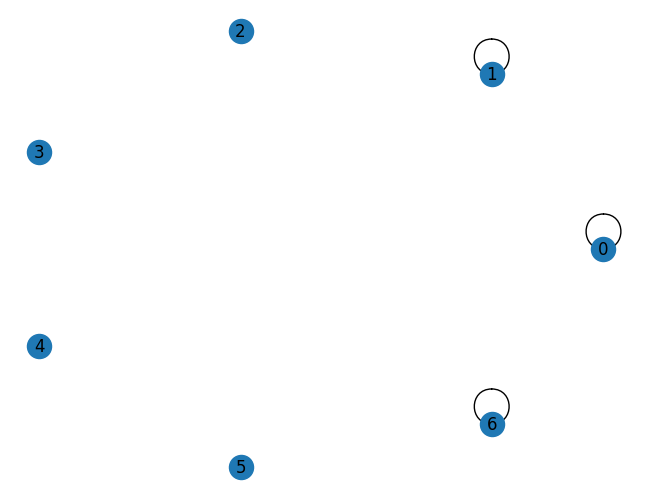

In [11]:
import numpy as np
import networkx as nx
from itertools import product
from collections import defaultdict
import random

# -- (Mantenha o código do treino como antes) --

# Função para gerar um novo grafo amostrado
def gerar_novo_grafo(num_nos):
    # Amostra Z ~ N(0,1)
    Z = np.random.randn(num_nos, latent_dim)

    # Decoder para gerar a matriz de adjacência predita
    A_pred = np.zeros((num_nos, num_nos))
    for i, j in product(range(num_nos), repeat=2):
        z_ij = np.concatenate([Z[i], Z[j]])
        h1 = relu(z_ij @ W_dec1 + b_dec1)
        out = sigmoid(h1 @ W_dec2 + b_dec2)
        A_pred[i, j] = out

    # Binarizar matriz para criar grafo (threshold 0.5)
    A_bin = (A_pred > 0.5).astype(float)

    # Garantir matriz simétrica para grafo não-direcionado
    A_bin = np.maximum(A_bin, A_bin.T)

    # Criar grafo NetworkX
    G_novo = nx.from_numpy_array(A_bin)

    return G_novo

# Exemplo de uso após treinamento:
novo_grafo = gerar_novo_grafo(7)  # gera grafo com 7 nós

# Plot para visualizar
import matplotlib.pyplot as plt
nx.draw_circular(novo_grafo, with_labels=True)
plt.show()


/var/folders/sb/p0pt20h1545bjmrdc9_kmffw0000gn/T/ipykernel_42133/462284719.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A_pred[i, j] = out


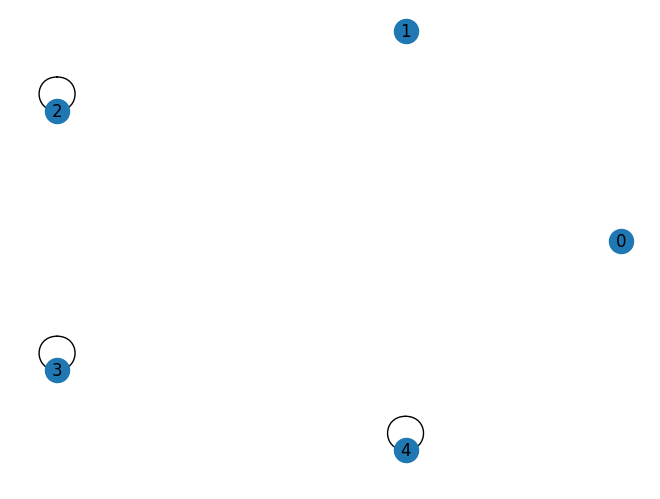

In [12]:
# Exemplo de uso após treinamento:
novo_grafo = gerar_novo_grafo(5)  # gera grafo com 7 nós

# Plot para visualizar
import matplotlib.pyplot as plt
nx.draw_circular(novo_grafo, with_labels=True)
plt.show()